In [1]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 11.6 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2


In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import torch
from torch.utils.data import DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from datasets import Dataset, DatasetDict
import warnings
warnings.filterwarnings("ignore")

In [4]:
test_data = pd.read_csv('/content/test (1).csv', encoding='ISO-8859-1')
train_data = pd.read_csv('/content/train.csv', encoding='ISO-8859-1')

In [5]:
train_data.head()

,textID,text,selected_text,sentiment,Time of Tweet,Age of User,Country,Population -2020,Land Area (Km²),Density (P/Km²)
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,morning,0-20,Afghanistan,38928346,652860.0,60
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,noon,21-30,Albania,2877797,27400.0,105
2,088c60f138,my boss is bullying me...,bullying me,negative,night,31-45,Algeria,43851044,2381740.0,18
3,9642c003ef,what interview! leave me alone,leave me alone,negative,morning,46-60,Andorra,77265,470.0,164
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,noon,60-70,Angola,32866272,1246700.0,26


In [6]:
train_data = train_data[['text', 'sentiment']]
test_data = test_data[['text', 'sentiment']]

In [7]:
train_data['label'] = train_data['sentiment'].map({'negative': -1, 'neutral': 0, 'positive': 1})
test_data['label'] = test_data['sentiment'].map({'negative': -1, 'neutral': 0, 'positive': 1})

In [8]:
train_data.head()

,text,sentiment,label
0,"I`d have responded, if I were going",neutral,0
1,Sooo SAD I will miss you here in San Diego!!!,negative,-1
2,my boss is bullying me...,negative,-1
3,what interview! leave me alone,negative,-1
4,"Sons of ****, why couldn`t they put them on t...",negative,-1


In [9]:
len(train_data), len(test_data)

(27481, 4815)

In [10]:
train_dataset = Dataset.from_pandas(train_data)
test_dataset = Dataset.from_pandas(test_data)
dataset = DatasetDict({'train': train_dataset, 'test': test_dataset})

In [11]:
checkpoint = "bert-base-uncased"

tokenizer = AutoTokenizer.from_pretrained(checkpoint)

def tokenize_function(batch):
  texts = [str(t) for t in batch["text"]]
  return tokenizer(texts, padding=True, truncation=True)

tokenized_dataset = dataset.map(tokenize_function, batched=True)


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/27481 [00:00<?, ? examples/s]

Map:   0%|          | 0/4815 [00:00<?, ? examples/s]

In [ ]:
label = {"negative": -1, "neutral": 0, "positive": 1 }
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=3, id2label= label, label2id=label)

training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    num_train_epochs=3,
    per_device_train_batch_size=64,
    per_device_eval_batch_size=64,
    load_best_model_at_end=True,
    logging_dir="./logs",
    report_to="none"
)

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    preds = predictions.argmax(axis=1)
    return classification_report(labels, preds, target_names=label.values(), output_dict=True)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

trainer.train()

Epoch,Training Loss,Validation Loss,Negative,Neutral,Positive,Accuracy,Macro avg,Weighted avg
1,No log,0.496309,"{'precision': 0.8539192399049881, 'recall': 0.7182817182817183, 'f1-score': 0.7802495930548019, 'support': 1001.0}","{'precision': 0.7205793602896802, 'recall': 0.8349650349650349, 'f1-score': 0.7735665694849369, 'support': 1430.0}","{'precision': 0.8618357487922705, 'recall': 0.8087035358114234, 'f1-score': 0.8344246959775491, 'support': 1103.0}",0.793718,"{'precision': 0.812111449662313, 'recall': 0.7873167630193922, 'f1-score': 0.7960802861724293, 'support': 3534.0}","{'precision': 0.802435335392476, 'recall': 0.7937181663837012, 'f1-score': 0.7944540115094944, 'support': 3534.0}"
2,0.530300,0.503552,"{'precision': 0.7633242999096658, 'recall': 0.8441558441558441, 'f1-score': 0.801707779886148, 'support': 1001.0}","{'precision': 0.7705035971223022, 'recall': 0.7489510489510489, 'f1-score': 0.7595744680851064, 'support': 1430.0}","{'precision': 0.8640308582449373, 'recall': 0.8123300090661831, 'f1-score': 0.8373831775700935, 'support': 1103.0}",0.795699,"{'precision': 0.7992862517589684, 'recall': 0.8018123007243587, 'f1-score': 0.7995551418471161, 'support': 3534.0}","{'precision': 0.7976609521048764, 'recall': 0.7956989247311828, 'f1-score': 0.7957936111736134, 'support': 3534.0}"
3,0.334600,0.606910,"{'precision': 0.7900497512437811, 'recall': 0.7932067932067932, 'f1-score': 0.7916251246261217, 'support': 1001.0}","{'precision': 0.7610371408549405, 'recall': 0.7594405594405594, 'f1-score': 0.760238011900595, 'support': 1430.0}","{'precision': 0.8421052631578947, 'recall': 0.8413417951042611, 'f1-score': 0.8417233560090703, 'support': 1103.0}",0.794567,"{'precision': 0.7977307184188721, 'recall': 0.7979963825838712, 'f1-score': 0.7978621641785956, 'support': 3534.0}","{'precision': 0.7945571640296399, 'recall': 0.7945670628183361, 'f1-score': 0.7945608286492936, 'support': 3534.0}"


Trainer is attempting to log a value of "{'precision': 0.8539192399049881, 'recall': 0.7182817182817183, 'f1-score': 0.7802495930548019, 'support': 1001.0}" of type <class 'dict'> for key "eval/negative" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'precision': 0.7205793602896802, 'recall': 0.8349650349650349, 'f1-score': 0.7735665694849369, 'support': 1430.0}" of type <class 'dict'> for key "eval/neutral" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'precision': 0.8618357487922705, 'recall': 0.8087035358114234, 'f1-score': 0.8344246959775491, 'support': 1103.0}" of type <class 'dict'> for key "eval/positive" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'precision': 0.81211

TrainOutput(global_step=1290, training_loss=0.385979934810668, metrics={'train_runtime': 1369.1055, 'train_samples_per_second': 60.214, 'train_steps_per_second': 0.942, 'total_flos': 4594182275477088.0, 'train_loss': 0.385979934810668, 'epoch': 3.0})

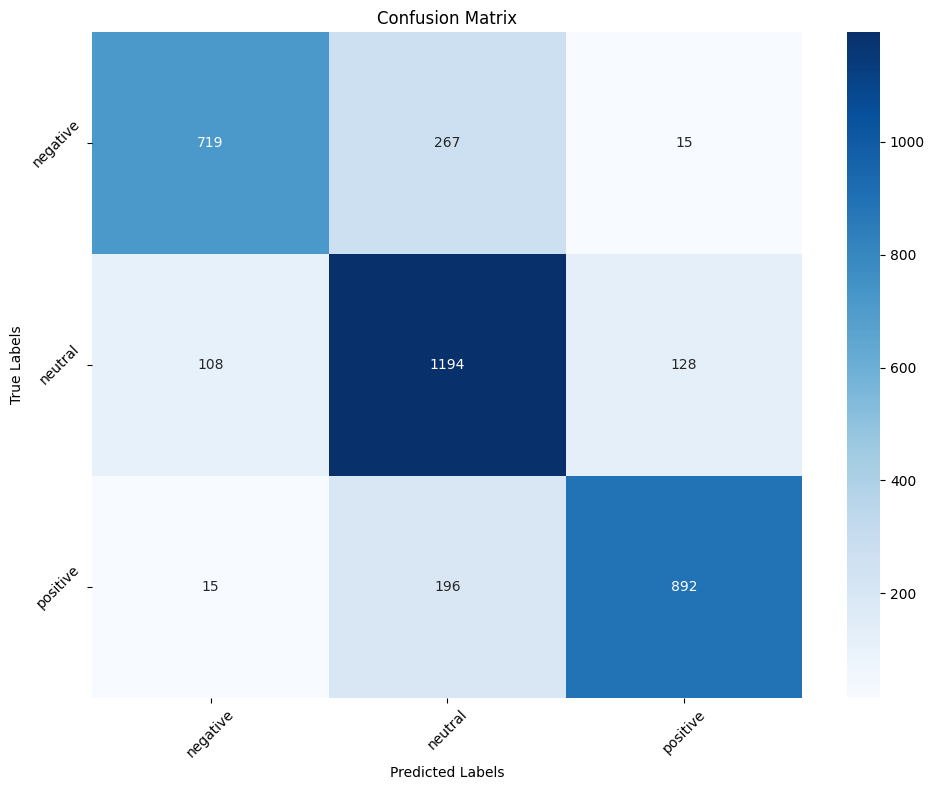

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)
labels = list(label.values())

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
from tabulate import tabulate

# Print overall stats
print("📌 General Evaluation Metrics:")
print(f"  🔹 Loss: {eval_results['eval_loss']:.4f}")
print(f"  🔹 Accuracy: {eval_results['eval_accuracy']:.4f}")
print(f"  ⏱️ Runtime: {eval_results['eval_runtime']:.2f}s | Samples/sec: {eval_results['eval_samples_per_second']:.2f}")

# Print class-wise metrics
print("\n📈 Per-Class Metrics:")
rows = []
for label in ['eval_negative', 'eval_neutral', 'eval_positive']:
    metrics = eval_results[label]
    rows.append([
        label.replace("eval_", "").capitalize(),
        f"{metrics['precision']:.4f}",
        f"{metrics['recall']:.4f}",
        f"{metrics['f1-score']:.4f}",
        int(metrics['support'])
    ])

print(tabulate(rows, headers=["Label", "Precision", "Recall", "F1-Score", "Support"], tablefmt="fancy_grid"))

# Print macro & weighted avg
print("\n📊 Averages:")
macro = eval_results['eval_macro avg']
weighted = eval_results['eval_weighted avg']

print(tabulate([
    ["Macro Avg", f"{macro['precision']:.4f}", f"{macro['recall']:.4f}", f"{macro['f1-score']:.4f}"],
    ["Weighted Avg", f"{weighted['precision']:.4f}", f"{weighted['recall']:.4f}", f"{weighted['f1-score']:.4f}"],
], headers=["Type", "Precision", "Recall", "F1-Score"], tablefmt="fancy_grid"))


📌 General Evaluation Metrics:
  🔹 Loss: 0.4963
  🔹 Accuracy: 0.7937
  ⏱️ Runtime: 10.83s | Samples/sec: 326.21

📈 Per-Class Metrics:
╒══════════╤═════════════╤══════════╤════════════╤═══════════╕
│ Label    │   Precision │   Recall │   F1-Score │   Support │
╞══════════╪═════════════╪══════════╪════════════╪═══════════╡
│ Negative │      0.8539 │   0.7183 │     0.7802 │      1001 │
├──────────┼─────────────┼──────────┼────────────┼───────────┤
│ Neutral  │      0.7206 │   0.835  │     0.7736 │      1430 │
├──────────┼─────────────┼──────────┼────────────┼───────────┤
│ Positive │      0.8618 │   0.8087 │     0.8344 │      1103 │
╘══════════╧═════════════╧══════════╧════════════╧═══════════╛

📊 Averages:
╒══════════════╤═════════════╤══════════╤════════════╕
│ Type         │   Precision │   Recall │   F1-Score │
╞══════════════╪═════════════╪══════════╪════════════╡
│ Macro Avg    │      0.8121 │   0.7873 │     0.7961 │
├──────────────┼─────────────┼──────────┼────────────┤
│ Weighted A